# Lab | Data Structuring and Combining Data

## Challenge 1: Combining & Cleaning Data

In this challenge, we will be working with the customer data from an insurance company, as we did in the two previous labs. The data can be found here:
- https://raw.githubusercontent.com/data-bootcamp-v4/data/main/file1.csv

But this time, we got new data, which can be found in the following 2 CSV files located at the links below.

- https://raw.githubusercontent.com/data-bootcamp-v4/data/main/file2.csv
- https://raw.githubusercontent.com/data-bootcamp-v4/data/main/file3.csv

Note that you'll need to clean and format the new data.

Observation:
- One option is to first combine the three datasets and then apply the cleaning function to the new combined dataset
- Another option would be to read the clean file you saved in the previous lab, and just clean the two new files and concatenate the three clean datasets

In [2]:
import pandas as pd
import numpy as np

In [3]:
def convert_data_types(df):
    categorical_cols = ['state', 'gender', 'education', 'policy_type', 'vehicle_class']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    if 'customer_lifetime_value' in df.columns:
        df['customer_lifetime_value'] = pd.to_numeric(df['customer_lifetime_value'], errors='coerce')
    return df  

def clean_open_complaints(df):
    def extract_middle(value):
        if isinstance(value, str) and '/' in value:
            parts = value.split('/')
            if len(parts) == 3 and parts[1].isdigit():
                return int(parts[1])
        try:
            return int(value)
        except:
            return np.nan
    if 'number_of_open_complaints' in df.columns:
        df['number_of_open_complaints'] = df['number_of_open_complaints'].apply(extract_middle)
    return df

def handle_nulls(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df[col].isnull().all():
            continue  # skip columns with all NaNs
        median = df[col].median()
        df[col] = df[col].fillna(median)

    for col in df.select_dtypes(include=['category', 'object']).columns:
        if df[col].isnull().all():
            continue  # skip columns with all NaNs
        mode = df[col].mode()[0]
        df[col] = df[col].fillna(mode)

    return df

def convert_numeric_to_int(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if df[col].isnull().sum() == 0:  # ensure no NaNs
            df[col] = df[col].astype(int)
    return df

def remove_duplicates(df):
    return df.drop_duplicates().reset_index(drop=True)

def clean_dataset_from_url(url, save_path):
    df = pd.read_csv(url)
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')  # Normalize column names
    df = convert_data_types(df)
    df = clean_open_complaints(df)
    df = handle_nulls(df)
    df = convert_numeric_to_int(df)
    df = remove_duplicates(df)
    df.to_csv(save_path, index=False)
    return df

In [4]:
url_file2 = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/file2.csv'
url_file3 = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/file3.csv'

cleaned_file2 = clean_dataset_from_url(url_file2, 'cleaned_file2.csv')
cleaned_file3 = clean_dataset_from_url(url_file3, 'cleaned_file3.csv')

In [6]:
df1 = pd.read_csv('cleaned_lab_data.csv')
df2 = pd.read_csv('cleaned_file2.csv')
df3 = pd.read_csv('cleaned_file3.csv')

merged_df = pd.concat([df1, df2, df3], ignore_index=True)
print(f"Merged dataset shape: {merged_df.shape}")

Merged dataset shape: (9138, 12)


In [7]:
print(merged_df.columns)

Index(['customer', 'state', 'gender', 'education', 'customer_lifetime_value',
       'income', 'monthly_premium_auto', 'number_of_open_complaints',
       'policy_type', 'vehicle_class', 'total_claim_amount', 'st'],
      dtype='object')


In [8]:
merged_df.rename(columns={
    'Total Claim Amount': 'total_claim_amount',
    'Customer Lifetime Value': 'customer_lifetime_value'
}, inplace=True)

In [9]:
filtered_df = merged_df.dropna(subset=['total_claim_amount', 'customer_lifetime_value'])

In [10]:
claim_75th = filtered_df['total_claim_amount'].quantile(0.75)
lifetime_25th = filtered_df['customer_lifetime_value'].quantile(0.25)

In [11]:
target_customers = filtered_df[
    (filtered_df['total_claim_amount'] > claim_75th) &
    (filtered_df['customer_lifetime_value'] < lifetime_25th)
]

In [12]:
summary = target_customers[['total_claim_amount', 'customer_lifetime_value']].describe()
print(summary)

       total_claim_amount  customer_lifetime_value
count          318.000000               318.000000
mean           736.616352              3502.503145
std            168.852550               618.688043
min            549.000000              1898.000000
25%            612.000000              3117.000000
50%            694.000000              3609.500000
75%            804.750000              3983.750000
max           1397.000000              4364.000000


In [13]:
state_counts = target_customers['state'].value_counts().head(10)
print("Top 10 States with High Claim + Low CLV Customers:")
print(state_counts)

Top 10 States with High Claim + Low CLV Customers:
state
California    105
Oregon         95
Arizona        55
Nevada         32
Washington     31
Name: count, dtype: int64


In [14]:
customer_type_counts = target_customers['customer'].value_counts()
print("\nCustomer Types with High Claim + Low CLV:")
print(customer_type_counts)


Customer Types with High Claim + Low CLV:
customer
BB10681    1
AL78075    1
LZ89773    1
EY89842    1
JS38272    1
          ..
TM28833    1
DQ15807    1
PK51938    1
FA82777    1
ZI48518    1
Name: count, Length: 318, dtype: int64


In [15]:
by_state = target_customers.groupby('state')[['total_claim_amount', 'customer_lifetime_value']].mean().sort_values(by='total_claim_amount', ascending=False)
print("\nAverage Total Claim Amount and CLV by State:")
print(by_state.head(10))


Average Total Claim Amount and CLV by State:
            total_claim_amount  customer_lifetime_value
state                                                  
Nevada              761.468750              3731.781250
Washington          743.225806              3506.580645
California          741.933333              3481.600000
Oregon              730.473684              3504.863158
Arizona             718.890909              3402.636364


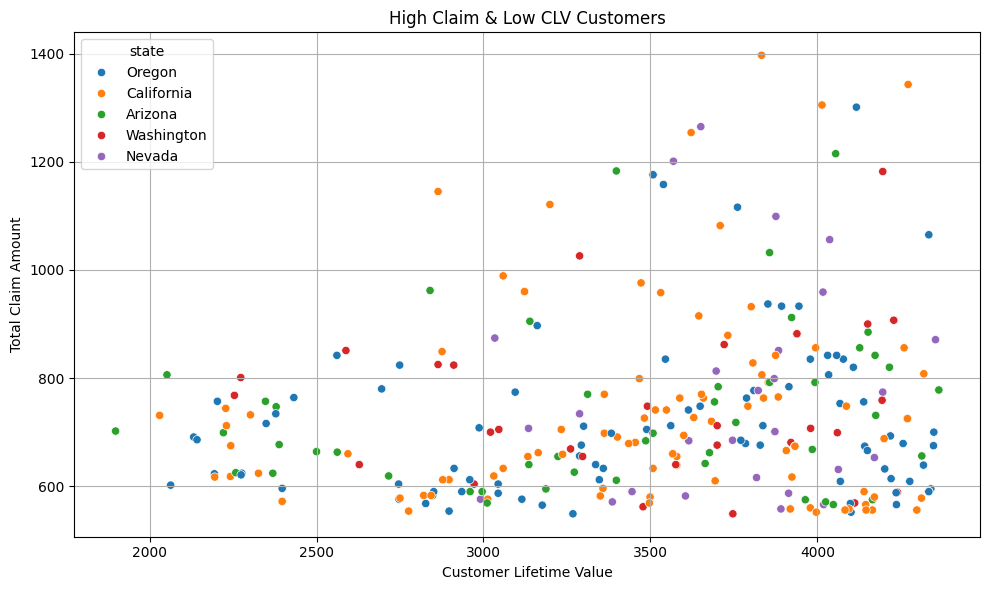

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=target_customers, x='customer_lifetime_value', y='total_claim_amount', hue='state')
plt.title('High Claim & Low CLV Customers')
plt.xlabel('Customer Lifetime Value')
plt.ylabel('Total Claim Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

# Challenge 2: Structuring Data

In this challenge, we will continue to work with customer data from an insurance company, but we will use a dataset with more columns, called marketing_customer_analysis.csv, which can be found at the following link:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis_clean.csv

This dataset contains information such as customer demographics, policy details, vehicle information, and the customer's response to the last marketing campaign. Our goal is to explore and analyze this data by performing data cleaning, formatting, and structuring.

In [18]:
url = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis_clean.csv"
df = pd.read_csv(url)

df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

print("Missing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

numeric_cols = ['income', 'customer_lifetime_value', 'monthly_premium_auto', 'total_claim_amount']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

# Step 6: Basic summary
print("\nSummary statistics:")
print(df[numeric_cols].describe())

categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

print("\nCorrelation matrix:")
print(df[numeric_cols].corr())

df.to_csv("marketing_customer_cleaned.csv", index=False)

Missing values per column:
 unnamed:_0                       0
customer                         0
state                            0
customer_lifetime_value          0
response                         0
coverage                         0
education                        0
effective_to_date                0
employmentstatus                 0
gender                           0
income                           0
location_code                    0
marital_status                   0
monthly_premium_auto             0
months_since_last_claim          0
months_since_policy_inception    0
number_of_open_complaints        0
number_of_policies               0
policy_type                      0
policy                           0
renew_offer_type                 0
sales_channel                    0
total_claim_amount               0
vehicle_class                    0
vehicle_size                     0
vehicle_type                     0
month                            0
dtype: int64

Data types:
 

1. You work at the marketing department and you want to know which sales channel brought the most sales in terms of total revenue. Using pivot, create a summary table showing the total revenue for each sales channel (branch, call center, web, and mail).
Round the total revenue to 2 decimal points.  Analyze the resulting table to draw insights.

2. Create a pivot table that shows the average customer lifetime value per gender and education level. Analyze the resulting table to draw insights.

In [19]:
url = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis_clean.csv"
df = pd.read_csv(url)

# Clean column names
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# Convert revenue column to numeric
df['total_claim_amount'] = pd.to_numeric(df['total_claim_amount'], errors='coerce')

# Pivot table for total revenue by sales channel
revenue_by_channel = pd.pivot_table(
    df,
    values='total_claim_amount',
    index='sales_channel',
    aggfunc='sum'
).round(2)

print("Total Revenue by Sales Channel:")
print(revenue_by_channel)

Total Revenue by Sales Channel:
               total_claim_amount
sales_channel                    
Agent                  1810226.82
Branch                 1301204.00
Call Center             926600.82
Web                     706600.04


In [20]:
df['customer_lifetime_value'] = pd.to_numeric(df['customer_lifetime_value'], errors='coerce')

# Pivot table for average CLV by gender and education
clv_by_gender_education = pd.pivot_table(
    df,
    values='customer_lifetime_value',
    index='gender',
    columns='education',
    aggfunc='mean'
).round(2)

print("\nAverage Customer Lifetime Value by Gender and Education:")
print(clv_by_gender_education)


Average Customer Lifetime Value by Gender and Education:
education  Bachelor  College   Doctor  High School or Below   Master
gender                                                              
F           7874.27  7748.82  7328.51               8675.22  8157.05
M           7703.60  8052.46  7415.33               8149.69  8168.83


## Bonus

You work at the customer service department and you want to know which months had the highest number of complaints by policy type category. Create a summary table showing the number of complaints by policy type and month.
Show it in a long format table.

*In data analysis, a long format table is a way of structuring data in which each observation or measurement is stored in a separate row of the table. The key characteristic of a long format table is that each column represents a single variable, and each row represents a single observation of that variable.*

*More information about long and wide format tables here: https://www.statology.org/long-vs-wide-data/*

In [21]:
url = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis_clean.csv"
df = pd.read_csv(url)

# Standardize column names
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# Convert 'effective_to_date' to datetime
df['effective_to_date'] = pd.to_datetime(df['effective_to_date'], errors='coerce')

# Extract month name from the date
df['month'] = df['effective_to_date'].dt.month_name()

# Ensure 'number_of_open_complaints' is numeric
df['number_of_open_complaints'] = pd.to_numeric(df['number_of_open_complaints'], errors='coerce').fillna(0).astype(int)

# Filter for actual complaints (non-zero)
df_complaints = df[df['number_of_open_complaints'] > 0]

# Group by policy type and month, count complaints
complaints_summary = df_complaints.groupby(['policy_type', 'month'])['number_of_open_complaints'].count().reset_index()

# Rename column for clarity
complaints_summary.rename(columns={'number_of_open_complaints': 'complaint_count'}, inplace=True)

# Sort for easier readability
complaints_summary = complaints_summary.sort_values(by=['policy_type', 'month'])

# Display the result
print("Long Format Table: Complaints by Policy Type and Month")
print(complaints_summary)

Long Format Table: Complaints by Policy Type and Month
      policy_type     month  complaint_count
0  Corporate Auto  February              205
1  Corporate Auto   January              240
2   Personal Auto  February              729
3   Personal Auto   January              861
4    Special Auto  February               39
5    Special Auto   January               43
